# 302.1. PSF Photometry for stars

<div>
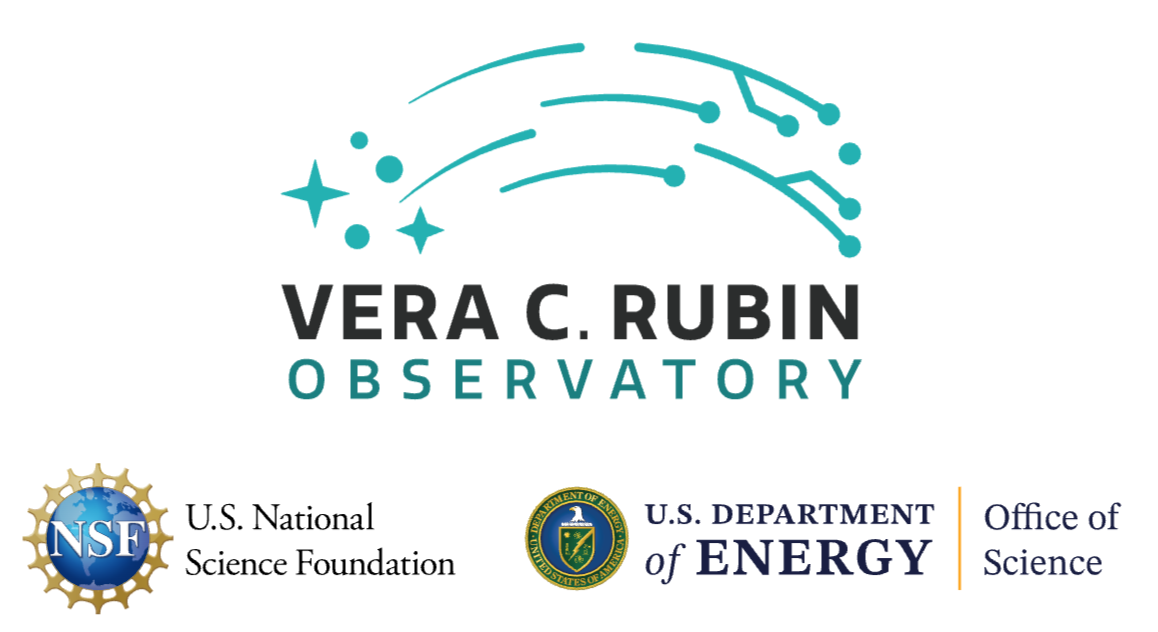
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="http://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.1.1 <br>
Last verified to run: 2025-08-27 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** To understand the Point Spread Function (PSF) photometry for stars.

**LSST data products:** `object`, `deep_coadd`

**Packages:** `lsst.daf.butler`, `lsst.rsp`, `lsst.geom`.

**Credit:**
Originally developed by the Rubin Community Science team. Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates PSF photometry for stars in the Fornax dSph field, as an example. PSF photometry is recommended for point-like sources. In DP1, each visit image is modeled with a spatially varying PSF using Piff [("PSF in the Full Field of View")](https://ui.adsabs.harvard.edu/abs/2021ascl.soft02024J/abstract). The coadd PSF stored with each deep coadd is the position-dependent weighted sum of the contributing PSF models of the input visit images with seeing FWHM < 1".7.

This notebook examines the spatial and magnitude distributions of bright, isolated stars selected for PSF modeling, with ~10\% reserved for validation. This tutorial visualizes the coadd PSF at the location of a selected star and display residuals between the model and the observed star. Finally, it compares PSF fluxes to aperture fluxes as a function of aperture size.

**Related tutorials:** See the 200-level DP1 tutorials on PSFs in `visit_image` and `deep_coadd`.

### 1.1. Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>), 
`matplotlib`, a comprehensive library for data visualization
(<a href="https://matplotlib.org/">matplotlib.org</a>;
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>), and `re`, a module to enable regular expression operations for pattern matching and text manipulation.

From the LSST pacakge (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>), import modules for accessing the Table Access Protocol (TAP) service, for retrieving datasets from the Butler, and geometry handling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.geom

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [2]:
rsp_tap = get_tap_service("tap")
assert rsp_tap is not None

Instantiate the Butler with the appropiate DP1 repository and collection. 

In [3]:
butler = Butler('dp1', collections='LSSTComCam/DP1')
assert butler is not None

Define a 1-degree radius around the central point of the Fornax dSph field.

In [4]:
ra_cen = 40.080
dec_cen = -34.450
radius = 1.0

Define `my_band` as the $r$ band.

In [5]:
my_band = 'r'

Define a function that computes quantile values within each magntidue bin, as used in Section 3.

In [7]:
def _binned_stats(x, y, nbins=30, q=(0.1, 0.5, 0.9)):
    x = np.asarray(x); y = np.asarray(y)
    m = np.isfinite(x) & np.isfinite(y)
    if not np.any(m):
        return np.array([]), [np.array([]) for _ in q]
    x, y = x[m], y[m]
    bins = np.linspace(np.nanmin(x), np.nanmax(x), nbins + 1)
    idx = np.digitize(x, bins) - 1
    xc = 0.5 * (bins[:-1] + bins[1:])
    qs = []
    for qq in q:
        arr = np.full(nbins, np.nan)
        for i in range(nbins):
            yy = y[idx == i]
            if yy.size > 0:
                arr[i] = np.nanpercentile(yy, 100 * qq)
        qs.append(arr)
    return xc, qs

## 2. PSF photometry in the Fornax dSph field

The `Object` table contains forced flux measurements on the deep coadded images at the locations of all objects detected with signal-to-noise ratio > 5 in a `deep_coadd` of any filter. Examine PSF photometry for stars in the Fornax dSph field.

### 2.1. Query for point-like objects

Query the `Object` table in the Fornax dSph field for coordinates, PSF photometry, multiple aperture fluxes, and flags indicating whether objects were used for PSF modeling or reserved for PSF evaluation, restricted to point-like sources (`extendedness` = 0 in `my_band`).

In [8]:
query = f"""SELECT objectId, x, y, coord_ra, coord_dec,
        {my_band}_psfMag, {my_band}_psfMagErr, {my_band}_psfFlux,
        {my_band}_ap03Flux, {my_band}_ap06Flux, {my_band}_ap09Flux,
        {my_band}_ap12Flux, {my_band}_ap17Flux, {my_band}_ap25Flux,
        {my_band}_ap35Flux, {my_band}_ap50Flux, {my_band}_ap70Flux,
        {my_band}_calib_psf_used, {my_band}_calib_psf_reserved
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
              CIRCLE('ICRS', {ra_cen}, {dec_cen}, {radius})) = 1
        AND {my_band}_extendedness = 0
        AND {my_band}_pixelFlags_inexact_psfCenter = 0
        ORDER BY objectId ASC
        """

In [24]:
job = rsp_tap.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

Job phase is COMPLETED


Fetch the results, store them as a table, then sort by `my_band` in ascending order, i.e., brighter stars first.

In [26]:
table = job.fetch_result().to_table()
table.sort(f'{my_band}_psfMag')
print(f'The query returned {len(table)} objects.')

The query returned 90589 objects.


Option to display the table of results.

In [11]:
# table

### 2.2. PSF modeling and evaluation stars

The LSST science pipelines use isolated, bright stars for PSF modeling, with roughly 10\% reserved to evaluate the PSF fit in DP1. Examine the number of stars used for PSF modeling and reserved for evaluation, along with their spatial and magnitude distributions.

In [44]:
psf_used = table['r_calib_psf_used'] == 1
psf_reserved = table['r_calib_psf_reserved'] == 1

print(f"Number of PSF stars used: {psf_used.sum()}")
print(f"Number of PSF stars reserved: {psf_reserved.sum()}")

Number of PSF stars used: 3902
Number of PSF stars reserved: 475


Plot the spatial and magnitude distributions of PSF stars relative to all retrieved point sources (`extendedness` = 0 in `my_band`) in the Fornax dSph field.

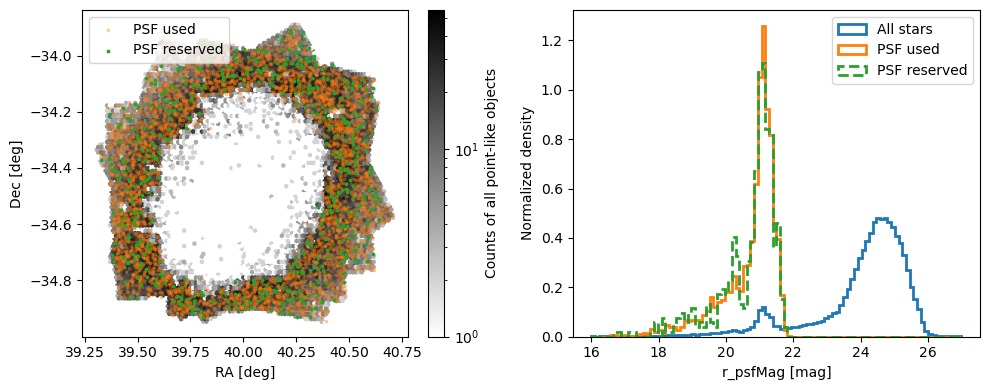

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

hb = ax1.hexbin(table['coord_ra'], table['coord_dec'], gridsize=100, bins='log', cmap='gray_r')
ax1.scatter(table['coord_ra'][psf_used], table['coord_dec'][psf_used], s=3, alpha=0.3, c='tab:orange', label='PSF used')
ax1.scatter(table['coord_ra'][psf_reserved], table['coord_dec'][psf_reserved], s=3, c='tab:green', label='PSF reserved')
ax1.legend(loc=2)
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('Dec [deg]')
cb = fig.colorbar(hb, ax=ax1, label='Counts of all point-like objects')

ax2.hist(table[f'{my_band}_psfMag'], bins=100, range=(16,27), density=True, histtype='step', lw=2, label='All stars')
ax2.hist(table[f'{my_band}_psfMag'][psf_used], bins=100, range=(16,27), density=True, histtype='step', lw=2, label='PSF used')
ax2.hist(table[f'{my_band}_psfMag'][psf_reserved], bins=100, range=(16,27), density=True, histtype='step', ls='--', lw=2, label='PSF reserved')
ax2.legend()
ax2.set_xlabel(f'{my_band}_psfMag [mag]')
ax2.set_ylabel('Normalized density')

plt.tight_layout()
plt.show()

> **Figure 1:** Spatial (left) and magnitude (right) distributions of all stars, PSF-used stars, and PSF-reserved stars, with PSF-selected stars being brighter and more isolated.

### 2.3. Photometric uncertainty

Visualize photometric uncertainty as a function of magnitude for stars used in PSF modeling and for those reserved to evaluate the PSF modeling. Also plot the average photometric uncertainty in 0.5-magnitude bins for all stars in the field.

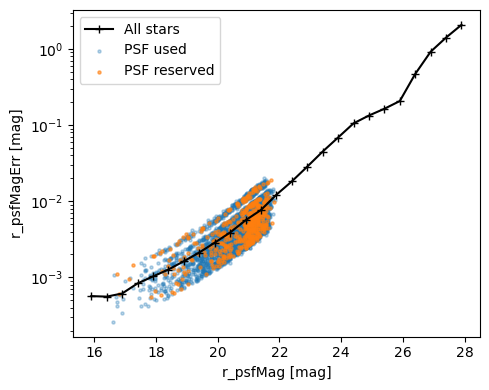

In [40]:
fig, ax = plt.subplots(figsize=(5, 4))

mag = np.ma.array(table[f'{my_band}_psfMag'])
magerr = np.ma.array(table[f'{my_band}_psfMagErr'])

bins = np.arange(mag.min(), mag.max(), 0.5)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
avg_magerr = [magerr[(mag >= b1) & (mag < b2)].mean() for b1, b2 in zip(bins[:-1], bins[1:])]

ax.plot(bin_centers, avg_magerr, c='k', marker="+", label='All stars')
ax.scatter(table[f'{my_band}_psfMag'][psf_used], table[f'{my_band}_psfMagErr'][psf_used],
                s=5, alpha=0.3, label="PSF used")
ax.scatter(table[f'{my_band}_psfMag'][psf_reserved], table[f'{my_band}_psfMagErr'][psf_reserved],
                s=5, alpha=0.6, label="PSF reserved")
ax.set_xlabel(f"{my_band}_psfMag [mag]")
ax.set_ylabel(f"{my_band}_psfMagErr [mag]")
ax.set_yscale("log")
ax.legend()

plt.tight_layout()
plt.show()

> **Figure 2:** Photometric uncertainty versus magnitude for PSF-used and PSF-reserved stars, and average uncertainties in 0.5-mag bins for all stars in the field. PSF stars are bright and typically exhibit <1\% uncertainty, consistent with the precision achieved by all bright stars.

In [43]:
del mag, magerr, bins, bin_centers, avg_magerr

### 2.4. Star-PSF comparison

#### 2.4.1. Retrieve a `deep_coadd` image

Select the brightest PSF-used star and display the residuals between the observed image and the PSF model at its location.

In [41]:
ra_star = table['coord_ra'][psf_used][0]
dec_star = table['coord_dec'][psf_used][0]

Query the butler for a `deep_coadd` image near the selected star.

In [42]:
center_coadd_datasetrefs = butler.query_datasets("deep_coadd",
                                                 where=f"band.name='{my_band}' AND\
                                                 patch.region OVERLAPS POINT(ra, dec)",
                                                 bind={"ra": ra_star, "dec": dec_star},
                                                 with_dimension_records=True,
                                                 order_by=["patch.tract"])

Option to display the dataset references.

In [ ]:
# center_coadd_datasetrefs

Get the first coadd image in the list and its World Coordinate System (WCS) information.

In [45]:
coadd = butler.get(center_coadd_datasetrefs[0])
wcs_coadd = coadd.getWcs()

#### 2.4.2. Make image cutouts

Find the pixel location of the selected star on the coadd image using the WCS function.

In [46]:
my_spherePoint = lsst.geom.SpherePoint(ra_star*lsst.geom.degrees,
                                       dec_star*lsst.geom.degrees)
point_image = wcs_coadd.skyToPixel(my_spherePoint)

Retrieve the PSF from the coadd, compute its image at the target position using the `computeImage()` method, convert it to float, and extract the pixel array.

In [47]:
psf_coadd = coadd.getPsf()
psf_image_coadd = psf_coadd.computeImage(point_image).convertF()
psf_array = psf_image_coadd.getArray()

Extract a cutout centered on the target star with the same dimensions as the PSF image, obtain its masked image, and normalize the pixel array by its total flux.

In [48]:
star_cutout = coadd.getCutout(point_image, psf_image_coadd.getDimensions()).getMaskedImage()
star_image_array = star_cutout.image.array
star_image_array /= star_image_array.sum()

#### 2.4.3. Display PSF residuals

Plot the observed star, the PSF model at its location, and their residual.

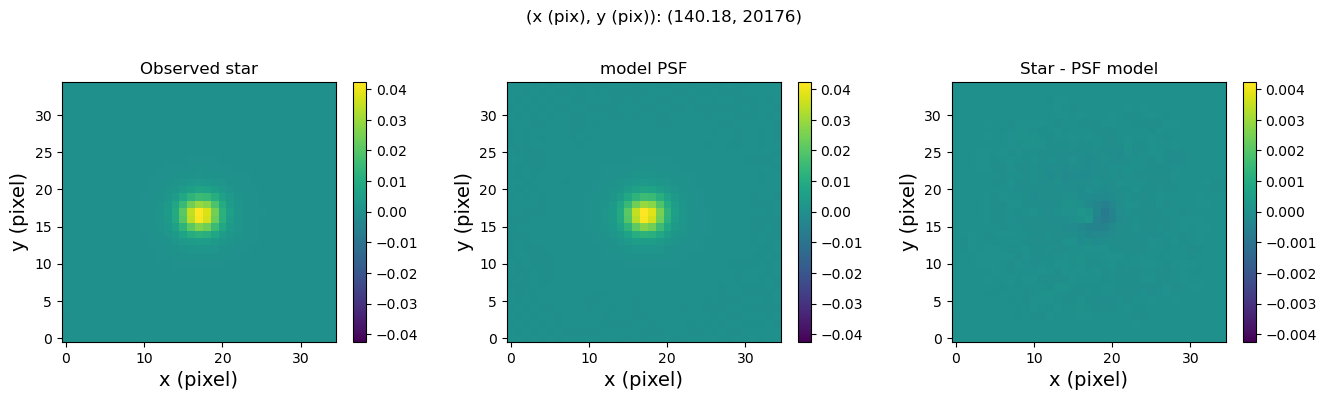

In [49]:
max_star_image_array = np.max(np.abs(star_image_array))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.3, left=0.07, right=0.95, bottom=0.15, top=0.8)
fig.suptitle(f"(x (pix), y (pix)): {point_image}", fontsize=12)

images = [
    (star_image_array, 'Observed star', max_star_image_array),
    (psf_array, f'model PSF', max_star_image_array),
    (star_image_array - psf_array,
     f'Star - PSF model', max_star_image_array/10)
]

for ax, (img, title, v) in zip(axes, images):
    im = ax.imshow(img, vmin=-v, vmax=v, cmap='viridis', origin='lower', aspect='auto')
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('x (pixel)', fontsize=14)
    ax.set_ylabel('y (pixel)', fontsize=14)
    ax.set_title(title, fontsize=12)

> **Figure 3:** Observed star (left), PSF model at the same location (middle), and residual image (right). The small residuals demonstrate the high quality of the PSF fit.

## 3. Compare PSF and Aperture fluxes

In principle, the PSF model captures 100\% of a point source’s flux. This section examines the fraction of stellar flux recovered by aperture photometry, comparing aperture fluxes with PSF fluxes as a function of aperture radius from 3 to 70 pixels centered on stellar positions.

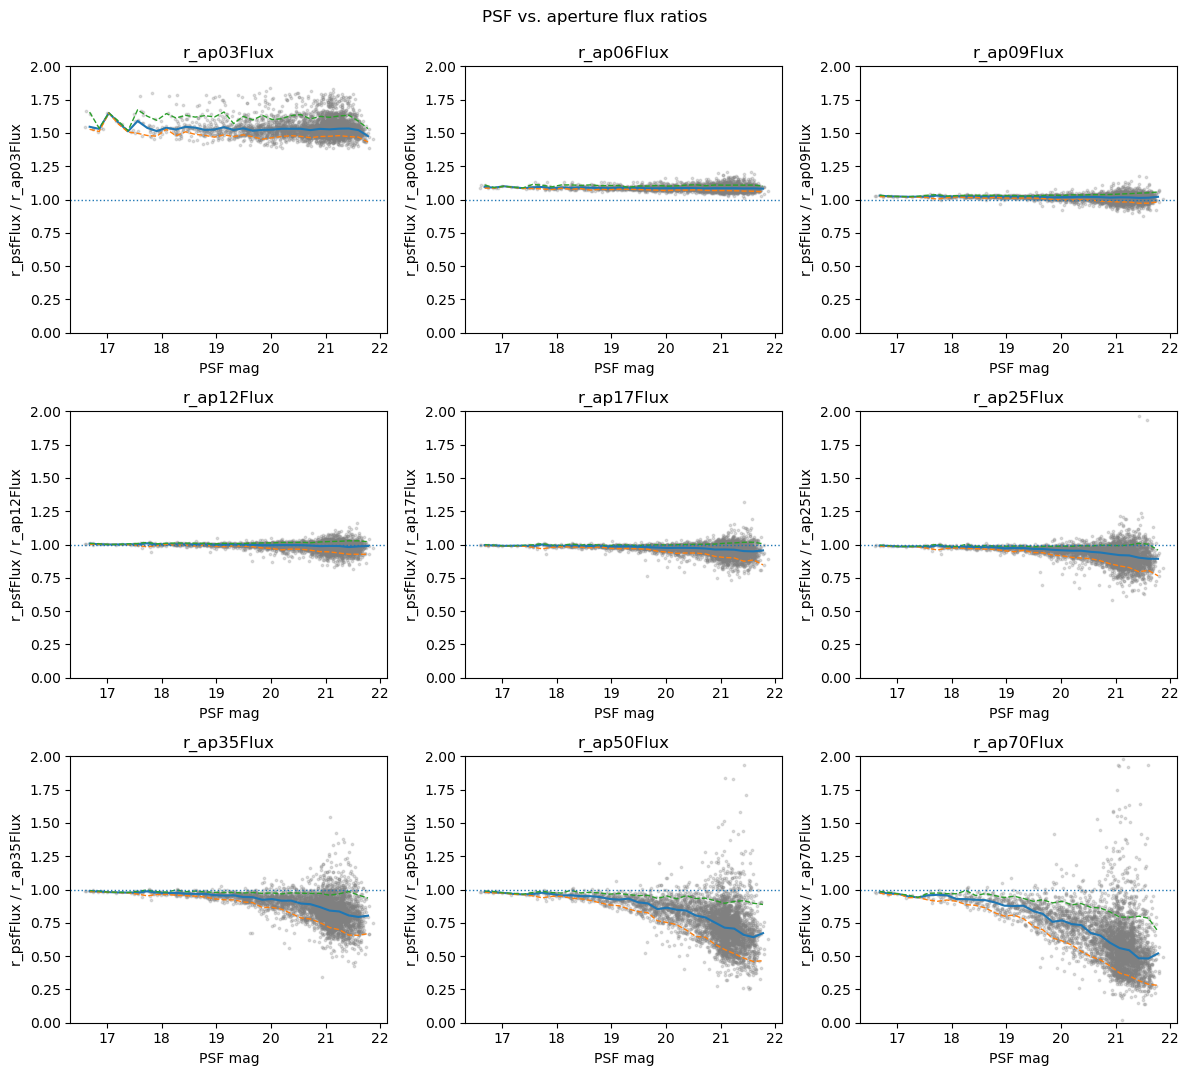

In [52]:
colnames = table.colnames
ap_cols = [c for c in colnames if re.match(r"^r_ap\d+Flux$", c)]
ap_cols.sort(key=lambda s: int(re.search(r"ap(\d+)", s).group(1)))

psf = table[f"{my_band}_psfFlux"][psf_used]
psfmag = table[f"{my_band}_psfMag"][psf_used]
m = np.isfinite(psf) & (psf > 0)

ncols = 3
nrows = int(np.ceil(len(ap_cols) / ncols)) if ap_cols else 1
fig1, axes1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows), squeeze=False)
axes1 = axes1.ravel()

for ax, ap_col in zip(axes1, ap_cols):
    ap = table[psf_used][ap_col]
    mm = m & np.isfinite(ap) & (ap > 0)
    x = psfmag[mm]
    ratio = psf[mm] / ap[mm]

    ax.scatter(x, ratio, s=3, alpha=0.25, c='gray')
    xc, (q10, q50, q90) = _binned_stats(x, ratio, nbins=30, q=(0.1, 0.5, 0.9))
    ax.plot(xc, q50, lw=1.5)
    ax.plot(xc, q10, lw=1, linestyle="--")
    ax.plot(xc, q90, lw=1, linestyle="--")

    ax.axhline(1.0, lw=1, linestyle=":")
    ax.set_ylabel(f"r_psfFlux / {ap_col}")
    ax.set_xlabel("PSF mag")
    ax.set_ylim(0, 2)
    ax.set_title(ap_col)

for j in range(len(ap_cols), len(axes1)):
    fig1.delaxes(axes1[j])

fig1.tight_layout()
fig1.suptitle("PSF vs. aperture flux ratios", y=1.02)
plt.show()

> **Figure 4:** Each panel shows the ratio of PSF flux to a given aperture flux as a function of PSF mangitude for stars in the field. The aperture size ranges from 3 pixels to 70 pixels. Ratio values > 1 indicate apertures too small to capture the total stellar flux, while values < 1 suggest contamination from neighboring sources due to too large aperture sizes. 

## 4. Exercise for the learner

Display the PSF residuals for the faintest PSF-used star and compare them with those of the brightest PSF-used star, as shown in Figure 3. Also compare these with the residuals of the brightest and faintest PSF-reserved stars.